<a href="https://colab.research.google.com/github/alouwyck/maxsypy/blob/main/seminaries/UM6P_jan_2025/Seminary_UM6P_Jan_2025_Part_4_Water_budget_myth_and_superposition_principle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

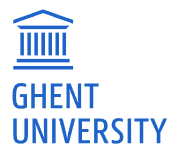<br>


**Axisymmetric Flow in Multilayer Aquifer Systems**<br>
Seminary on Groundwater Modeling<br>
University Mohammed VI Polytechnic<br>
January 6, 2025<br>
Dr. Andy Louwyck

---



---

# **Part 4 - The Water Budget Myth and the Superposition Principle**

This notebook contains some code examples to illustrate "the water budget myth" and "the superposition principle" discussed in the fourth part of the presentation. The explanation provided with each example is relatively concise. If you want to get a good understanding of what's going on, I recommend reading the notebook side by side with the slides. For a full comprehension of the discussed models and the presented theory, I refer to [my PhD thesis](https://github.com/alouwyck/PhD) (Louwyck, 2023).

## 0. Import statements

We need the following libraries:
- [NumPy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/)

Importing module `inspect` will allow us to print the source code of the functions implemented in the `maxsypy` package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import inspect

We also clone the MAxSyPy package from GitHub for simulating axisymmetric groundwater flow:

In [2]:
import os, shutil

# remove directory 'maxsypy' first if it already exists
path = "maxsypy"
if os.path.exists(path):
    shutil.rmtree(path)

# clone maxsypy repository from Github
!git clone https://github.com/alouwyck/maxsypy


# put maxsypy package directory in the current working directory
os.rename(path, 'temp')
shutil.copytree(os.path.join('temp', path), path);
shutil.rmtree('temp')

Cloning into 'maxsypy'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 152 (delta 39), reused 0 (delta 0), pack-reused 60 (from 1)
Receiving objects: 100% (152/152), 6.34 MiB | 12.86 MiB/s, done.
Resolving deltas: 100% (73/73), done.


The [MAxSyPy](https://github.com/alouwyck/maxsypy) package implements several analytical and semi-analytical solutions discussed in my PhD thesis (Louwyck, 2023). We will also use the [TTim](https://ttim.readthedocs.io/en/latest) package:

In [3]:
!pip install ttim -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00


In [4]:
import ttim

## 1. The island examples

First, consider a circular island situated in a freshwater lake. The phreatic aquifer on the island is recharged by rainfall and discharges into the lake. It is bounded below by an impermeable aquiclude, and a well at the center of the island extracts water from it at constant pumping rate.

In [5]:
Q  = -200              # pumping rate (m³/d): Q < 0 -> extraction
K  = 10                # horizontal conductivity (m/d) of the phreatic aquifer
r_out = 1000           # radius (m) of the island = distance of constant-head boundary
h_out = 20             # water level (m) of the lake = constant-head boundary of the island
T  = K * h_out         # aquifer transmissivity (m²/d)
N  = 20 / 1000 / 365   # infiltration flux (m/d)

We can use function `bredehoeft` to solve this simple problem:

In [6]:
from maxsypy.special import bredehoeft

print(inspect.getdoc(bredehoeft))

Calculate the solution for steady flow to a pumping well in the center of an island with recharge.
The solution is obtained by superimposing the Thiem formula and the equation for a circular infiltration area.

The island case is discussed in the papers by Bredehoeft about the water budget myth.

Parameters
----------
r : array_like
  Radial distances [L], which should be smaller than `r_out`.
T : float
  Aquifer transmissivity [L²/T].
Q : float
  Pumping rate [L³/T].
N : float
  Infiltration flux [L/T].
r_out : float
      Radial distance [L] of the outer aquifer boundary.
r_in : float, default: 0.0
     Pumping well radius [L], which coincides with the inner model boundary.
h_out : float, default: 0.0
      Hydraulic head [L] at the outer aquifer boundary at distance `r_out`.

Returns
-------
h : ndarray
  Hydraulic heads [L] at given distances `r`. The shape of `h` is the same as the shape of `r`.


Usually, two models are developed to determine the drawdown caused by the pumping well:
1. the first model simulates the steady-state flow before the extraction starts;
2. the second model simulates the flow during the pumping using the results of the first model to define the initial conditions.

Finally, drawdown is calculated as the head difference between the two models. Let's illustrate this for the island example:

In [7]:
r = np.logspace(-1, np.log10(r_out), 1000)  # radial distances (m)

h0 = bredehoeft(r=r, N=N, T=T, Q=0, r_out=r_out, h_out=h_out)  # head before pumping (m) -> Q = 0!
h =  bredehoeft(r=r, N=N, T=T, Q=Q, r_out=r_out, h_out=h_out)  # head during pumping (m)

s = h0 - h  # drawdown (m) = initial head - head during pumping

As we assume the aquifer transmissivity is constant, which implies the effect of infiltration and pumping on the saturated thickness of the aquifer is negligibly small, the model is linear, and drawdown due to pumping can be simulated directly using the Thiem equation:

In [8]:
from maxsypy.special import thiem

s_th = -thiem(r=r, T=T, Q=Q, r_out=r_out);

Let's plot the results to verify that both approaches indeed yield the same drawdown curve:

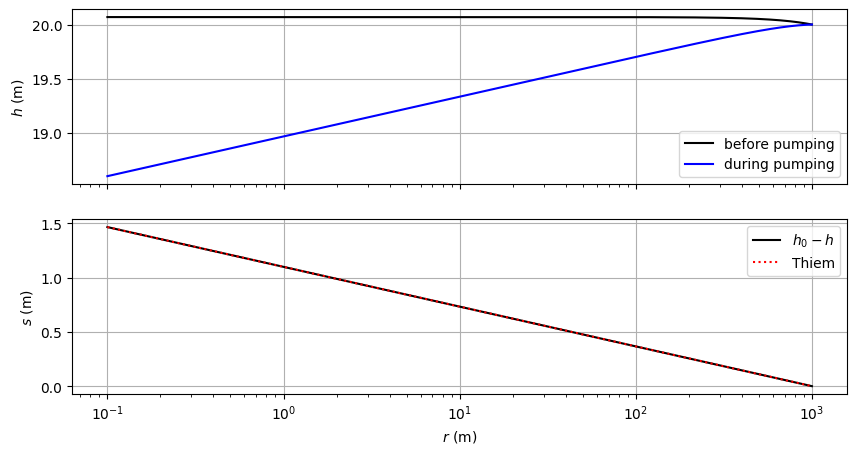

In [9]:
_, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
ax1.semilogx(r, h0, 'k-', r, h, 'b-');
ax1.legend(['before pumping', 'during pumping'], loc='lower right');
ax1.set_ylabel('$h$ (m)');
ax1.grid();

ax2.semilogx(r, s, 'k-', r, s_th, 'r:');
ax2.legend(['$h_0 - h$', 'Thiem']);
ax2.set_xlabel('$r$ (m)');
ax2.set_ylabel('$s$ (m)');
ax2.grid();

**If the model is linear, then the superposition principle is valid.** In this example, superposition may be applied if recharge is negligibly small, and if the aquifer's saturated thickness is relatively large, a typical condition in the arid west of the USA. Note that in this case, the simulated drawdown is not a function of the recharge.

Suppose now the circular island is reclaimed from the lake in an area where the climate is humid and infiltration cannot be ignored. This is a typical condition in deltaic or low lying polder areas, which are found in the Netherlands and the northern part of Belgium. On the island, a dense network of canals and ditches is present which drains the excess of water from rainfall. In this case, the solution developed by Ernst can be used to solve the problem:

In [10]:
from maxsypy.special import ernst

print(inspect.getdoc(ernst))

Simulate steady flow to a pumping well in a phreatic aquifer subject to uniform recharge and drainage.
The well is fully penetrating and extracts water at a constant pumping rate.

Parameters
----------
r : array_like
  One-dimensional array with the radial distances [L].
T : float
  Aquifer transmissivity [L²/T].
c : float
  Drainage resistance [T].
N : float
  Infiltration flux [L/T].
Q : float
  Pumping rate [L³/T] of the well. 
  Negative as the model only simulates extractions.

Returns
-------
s : ndarray
  Drawdown [L] at distances `r`.
  The length of `s` equals the length of `r`.


To simulate the humid conditions on the polder island, we will increase the infiltration flux by a factor of 10. The Ernst model also requires a drainage resistance, which is set to 1 day. This low value reflects the effective drainage capacity of the dense network of ditches on the island.

In [11]:
N *= 10  # infiltration flux (m/d)
c = 1    # drainage resistance (d)

Let's calculate the drawdown in two steps again:

In [12]:
h0 = h_out - ernst(r=r, N=N, T=T, c=c, Q=0)  # head (m) before pumping -> Q = 0!
h =  h_out - ernst(r=r, N=N, T=T, c=c, Q=Q)  # head (m) during pumping
s =  h0 - h  # drawdown (m) = initial head - head during pumping

Note that function `ernst` returns drawdowns. However, as the drainage resistance is very low, initial head `h0` is equal to `h_out` at all distances from the well.

Let's simulate the same problem using the formulas of Thiem and de Glee:

In [13]:
from maxsypy.special import deglee

s_th = -thiem(r=r, T=T, Q=Q, r_out=r_out);
s_dg = -deglee(r=r, T=T, Q=Q, c_top=c);

Plotting the results:

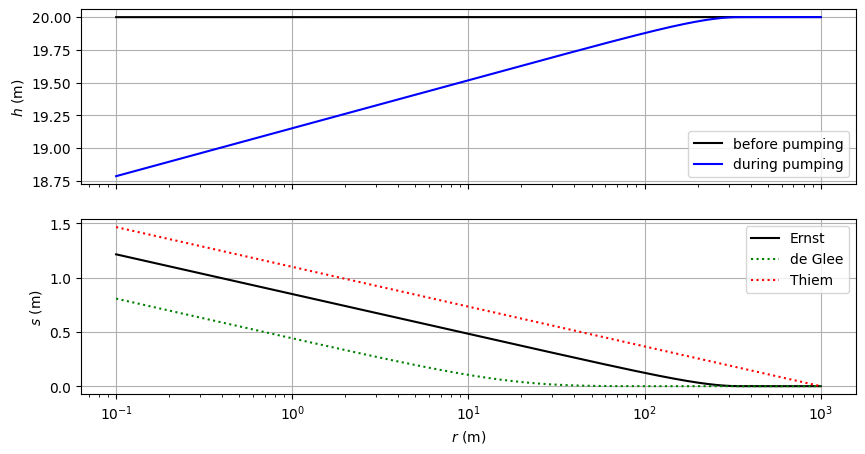

In [14]:
_, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
ax1.semilogx(r, h0, 'k-', r, h, 'b-');
ax1.legend(['before pumping', 'during pumping'], loc='lower right');
ax1.set_ylabel('$h$ (m)');
ax1.grid();

ax2.semilogx(r, s, 'k-', r, s_dg, 'g:', r, s_th, 'r:');
ax2.legend(['Ernst', 'de Glee', 'Thiem']);
ax2.set_xlabel('$r$ (m)');
ax2.set_ylabel('$s$ (m)');
ax2.grid();

Looking at the distance-drawdown graph, we see that the Ernst curve lies between the Thiem and de Glee curves. The latter are simulated using a linear model, while the Ernst model is nonlinear due to the drainage boundary condition defined at the top of the aquifer. **If the model is nonlinear, then the superposition principle is not valid!** Note that in this situation, the simulated drawdown is a function of the recharge.

This example illustrates that drawdown can be calculated directly, i.e. using one model only, if the problem is linear. In this case, the initial conditions are irrelevant, as is the recharge. However, if the problem is nonlinear, the initial conditions including the recharge cannot be ignored. Under these circumstances, two models are usually required to obtain drawdown due to pumping: a first model to simulate the initial heads, and a second model to simulate the head during pumping. Note that function `ernst` also applies these two steps.

## 2. The superposition principle

In this section, two well-known examples of the application of the superposition principle are given. The first example applies *superposition in time* to simulate a recovery test, while the second example uses the *method of images* to simulate a pumping well close to a river.

### Theis' recovery test

It is straightforward to simulate a recovery test in a confined aquifer by applying the superposition method to the Theis solution.

We import function `theis_recovery` from module `maxsypy.special`. When we inspect the code, we see it uses function `theis` and it applies superposition in time. First, the pumping is simulated during the entire simulation period, that is during both the pumping and the recovery phase. Then the calculated drawdown for the recovery phase is corrected by superimposing the head change due to a well injecting water at the same rate.

In [15]:
from maxsypy.special import theis_recovery

print(inspect.getsource(theis_recovery))

def theis_recovery(r, t, T, S, Q, t_end, S2=None):
    """
    Simulate pumping followed by recovery in a confined aquifer. The well has an infinitesimal radius and extracts water
    at a constant pumping rate during the pumping phase. The pump is shut down completely at the beginning of the
    recovery phase. The solution is obtained by applying the superposition principle to the Theis equation.

    Parameters
    ----------
    r : array_like
      One-dimensional array with the radial distances [L].
    t : array_like
      One-dimensional array with the simulation times [T].
    T : float
      Aquifer transmissivity [L²/T].
    S : float
      Aquifer storativity [-] during pumping.
    Q : float
      Pumping rate [L³/T] of the well.
    t_end : float
          Time [T] at which the pumping stops and the recovery starts.
    S2 : float, default: None
       Aquifer storativity [-] during recovery. If `S2` is not given, `S2` is set to `S`.

    Returns
    -------
    s : ndarr

Let's illustrate this using the running example from previous notebooks:

In [16]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
S  = 0.1     # aquifer storativity (-)

We simulate the head change in the pumping well with a radius of 0.1 m. The well extracts water from the confined aquifer during 1 day, after which its pump is shut down:

In [17]:
r = 0.1    # radial distance (m)
t_end = 1  # time at which pump is shut down
t = np.logspace(-5, np.log10(t_end), 1000)
t = np.hstack((t, t_end + t))  # simulation times (d)

Using **TTim**, it is very straightforward to simulate this pumping and recovery test:

In [18]:
model = ttim.ModelMaq(kaq=T, Saq=S, z=[1, 0],  # use T and S by setting aquifer thickness to unity
                      tmin=1e-5, tmax=10)

well = ttim.Well(model,
                 rw=1e-5,  # well-radius -> 0
                 tsandQ=[(0, Q),  # starting with the pumping phase
                         (1, 0)]  # recovery phase (Q=0) after 1 day
)

model.solve()

s_ttim = model.head(x=0, y=r, t=t).squeeze()

self.neq  1
solution complete


Let's compare the TTim simulation to the result obtained by applying the superposition method:

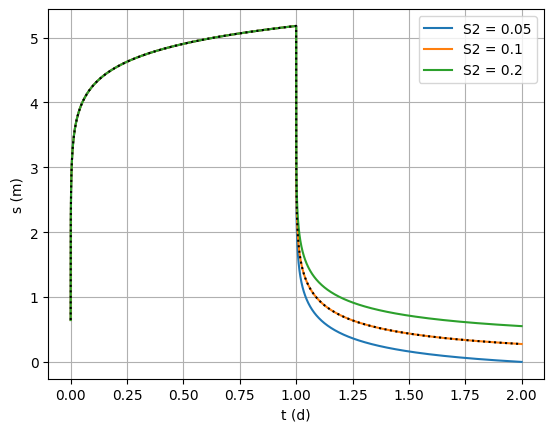

In [19]:
for S2 in np.array([0.5, 1, 2]) * S:  # storativity (-) during recovery
    s = theis_recovery(r=r, t=t, Q=Q, T=T, S=S, t_end=t_end, S2=S2)  # drawdown (m)
    plt.plot(t, s.squeeze(), '-', label="S2 = " + str(S2));

plt.plot(t, s_ttim, 'k:');  # drawdown (m) simulated using TTim

plt.xlabel('t (d)');
plt.ylabel('s (m)');
plt.legend();
plt.grid();

Both approaches virtually give the same time-drawdown curve. It is possible the aquifer storativity `S2` during recovery is different from the storativity `S` during pumping. That is why additional simulations were performed where `S2` is two times smaller and two times larger than `S`. Although the factor 2 may seem unrealistically large, it is chosen to obtain a clear visual distinction.

### A pumping well close to a river

By applying **the method of images**, it is possible to simulate flow to a pumping well close to a straight river with constant water level. We illustrate the method by applying it to the Theis equation:

In [20]:
from maxsypy.special import theis

We take the same example as before, and additionally, we define a north-south oriented river that is L = 100 m away from the pumping well.

In [21]:
Q  = -1000   # pumping rate (m³/d): Q < 0 -> extraction
K  = 10      # conductivity (m/d)
h0 = 20      # initial head = initial aquifer thickness (m)
T  = K * h0  # aquifer transmissivity (m²/d)
S  = 0.1     # aquifer storativity (-)
L  = 100     # horizontal distance (m) between well and rivier

The well is at position (0, 0), and if the river is located on the left of the well, then we need to define an image well at position (-2L, 0) that injects water at the same rate -Q. Superimposing the head changes of both the pumping well and the imaginary injection well creates a constant-head boundary that coincides with the river:

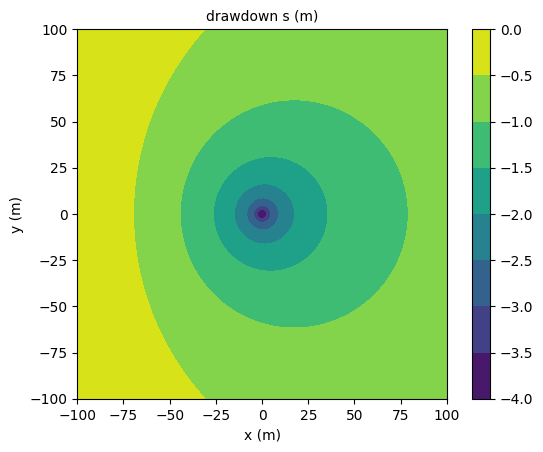

In [22]:
# applying the method of images

t = 1e3  # time (d)
x_pump, y_pump = 0, 0  # pumping well coordinates: (0, 0)
x_im, y_im = -2*L, 0   # image injection well coordinates: (-2L, 0)

x = y = np.linspace(-L, L, 100)     # x and y coordinates (m)
x_grid, y_grid = np.meshgrid(x, y)  # grid coordinates

r_pump = np.sqrt((x_grid - x_pump)**2 + (y_grid - y_pump)**2)  # distances (m) to pumping well
s_pump = theis(r=r_pump.flatten(), t=t, T=T, S=S, Q=Q);  # drawdown (m) due to pumping

r_im = np.sqrt((x_grid - x_im)**2 + (y_grid - y_im)**2)  # distances (m) to injection well
s_im = theis(r=r_im.flatten(), t=t, T=T, S=S, Q=-Q);  # head change (m) due to injection

s_theis = np.reshape(s_pump + s_im, x_grid.shape)
plt.contourf(x_grid, y_grid, s_theis);
plt.colorbar()
plt.gca().set_aspect('equal');
plt.xlabel('x (m)');
plt.ylabel('y (m)');
plt.title('drawdown s (m)', fontdict=dict(fontsize=10));

Recall that the radial distance $r$ between the well $(x_w, y_w)$ and a grid node $(x,y)$ is determined by the Euclidean distance between both points:

> $r = \sqrt{(x-x_w)^2 + (y-y_w)^2}$

The method of images can also be applied to simulate the effect of an impervious lateral boundary close to to the well. In this case, an image well extracting at the same pumping rate is used instead of an imaginary injection well.

As we already know, the Theis equation may be approximated by the Thiem equation for large values of time. The question that comes into mind here is which value for the radius of influence `R` do we have to choose? As the pumping and the injection are balanced, the value for `R` doesn't matter as long as it is sufficiently large:

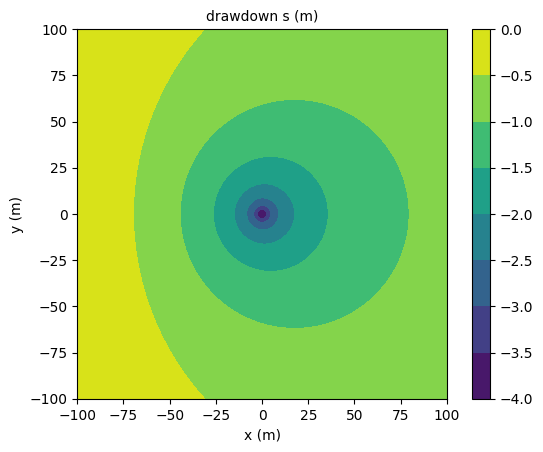

In [23]:
from maxsypy.special import thiem

R = 1e6  # setting R to a very large value
s_pump = thiem(r=r_pump.flatten(), T=T, Q=Q, r_out=R);  # drawdown (m) due to pumping
s_im = thiem(r=r_im.flatten(), T=T, Q=-Q, r_out=R);  # head change (m) due to injection
s_thiem = np.reshape(s_pump + s_im, x_grid.shape)

plt.contourf(x_grid, y_grid, s_thiem);
plt.colorbar()
plt.gca().set_aspect('equal');
plt.xlabel('x (m)');
plt.ylabel('y (m)');
plt.title('drawdown s (m)', fontdict=dict(fontsize=10));

As expected, we get the same contour plot as before!

Of course, the method of images can also be applied using **TTim**. However, the package also provides line sinks, which can be used to simulate the effect of rivers of all shapes. Let's illustrate this by adding a `HeadLineSinkString` to the corresponding Theis model:

In [24]:
# start with building the Theis model
model = ttim.ModelMaq(kaq=T, Saq=S, z=[1, 0], tmin=0.001, tmax=t)
well = ttim.Well(model, rw=1e-5, tsandQ=[(0, -Q)])

# add the line sink to the model
n = 50                             # the line sink is discretized into 50 nodes
ymax = 1000                        # maximum y-coordinate of the line sink
xls = -L * np.ones(n)              # x-coordinates of the nodes; the river is located at x=-L
yls = np.linspace(-ymax, ymax, n)  # y-coordinates of the nodes ranging from -ymax to ymax

river = ttim.HeadLineSinkString(
    model,                                 # add line sink to the model
    xy=list(zip(xls, yls, strict=False)),  # (x, y) coordinates of the nodes
    tsandh="fixed"                         # the river has a fixed level
)

# solve the model
model.solve()

self.neq  50
solution complete


Creating a contour plot with TTim takes too much time, and therefore, the head for a vertical cross-section is calculated:

In [25]:
irow = 50  # cross-section corresponding to horizontal line y = y[irow]
s_ttim = np.array([model.head(x=x, y=y[irow], t=t) for x in x]).squeeze()

Plotting the result:

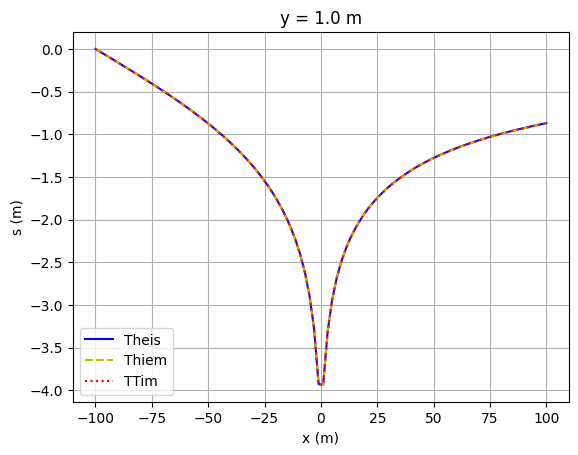

In [26]:
plt.plot(x, s_theis[irow, :], 'b-', label='Theis');
plt.plot(x, s_thiem[irow, :], 'y--', label='Thiem');
plt.plot(x, s_ttim, 'r:', label='TTim');
plt.legend(loc='lower left');
plt.grid();
plt.xlabel('x (m)');
plt.ylabel('s (m)');
plt.title(f'y = {np.round(y[irow])} m');

The three approaches virtually give the same results! When using TTim, the line sink should be long enough and have a sufficient number of nodes.

---